In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up module paths (adjust as needed)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including the Markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [2]:

# -------------------------------
# CIR Simulation Function
# -------------------------------
def cir_simulation(n_sample, T, a, b, sigma, dt, seed):
    """
    Simulate the CIR process using full truncation Euler:
      dr_t = a(b - r_t) dt + sigma * sqrt(max(r_t, 0)) * dW_t
    """
    np.random.seed(seed)
    r = np.zeros((T+1, n_sample))
    r[0, :] = b  # initial condition set at the long-term mean
    for t in range(1, T+1):
        Z = np.random.normal(size=n_sample)
        r_prev = r[t-1, :]
        r[t, :] = r_prev + a * (b - np.maximum(r_prev, 0)) * dt \
                        + sigma * np.sqrt(np.maximum(r_prev, 0)) * np.sqrt(dt) * Z
        r[t, :] = np.maximum(r[t, :], 0)  # enforce non-negativity
    return r

In [3]:
# -------------------------------
# Visualization of Sample Paths via Trees
# -------------------------------
# Option simulation settings for a 1-month period (30 days)
T = 30             # 30 time steps (days)
dt = 1 / 365       # each time step represents one day (annualized)

# Parameters for the CIR model:
# Process X: High mean reversion
a1 = 10          # high mean reverting speed
# Process Y: Low mean reversion
a2 = 0.2           # low mean reverting speed
b  = 5          # long-term mean rate (for both) in percentage -> 0.05
sigma = 1        # volatility parameter 0.1 scaled by sqrt 10

n_sample = 500     # number of sample paths for visualization
seed = 44

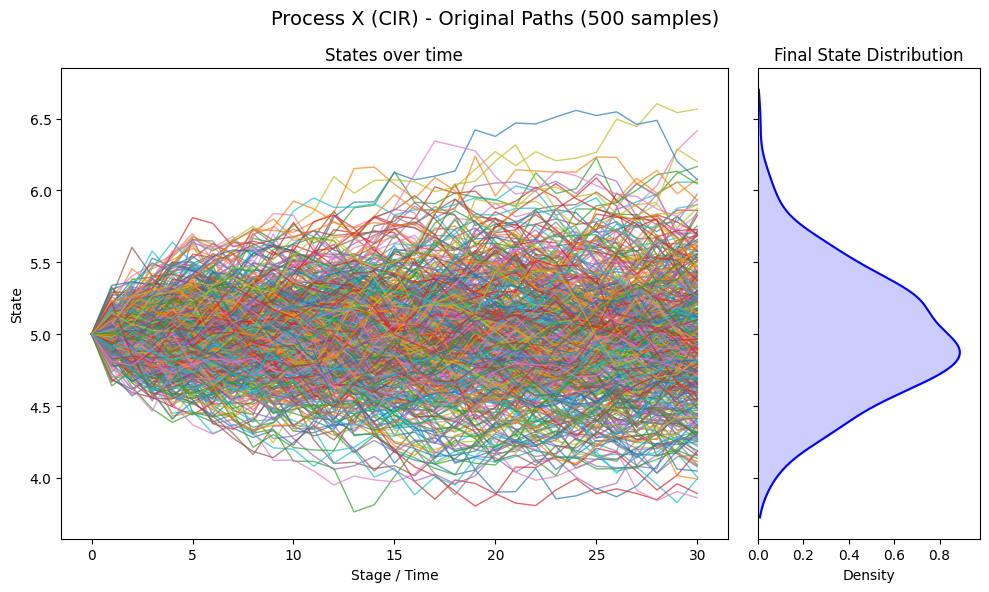

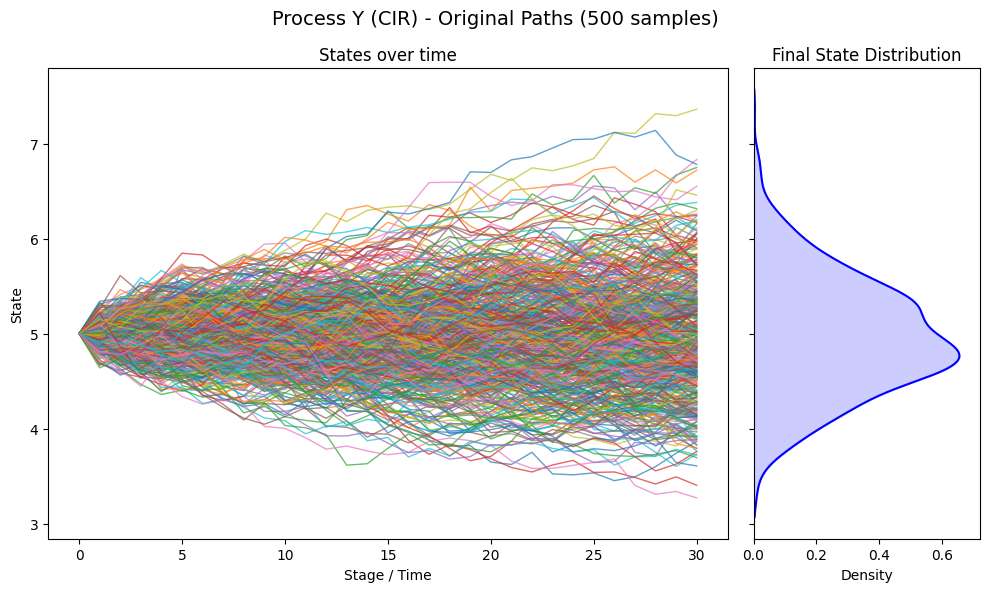

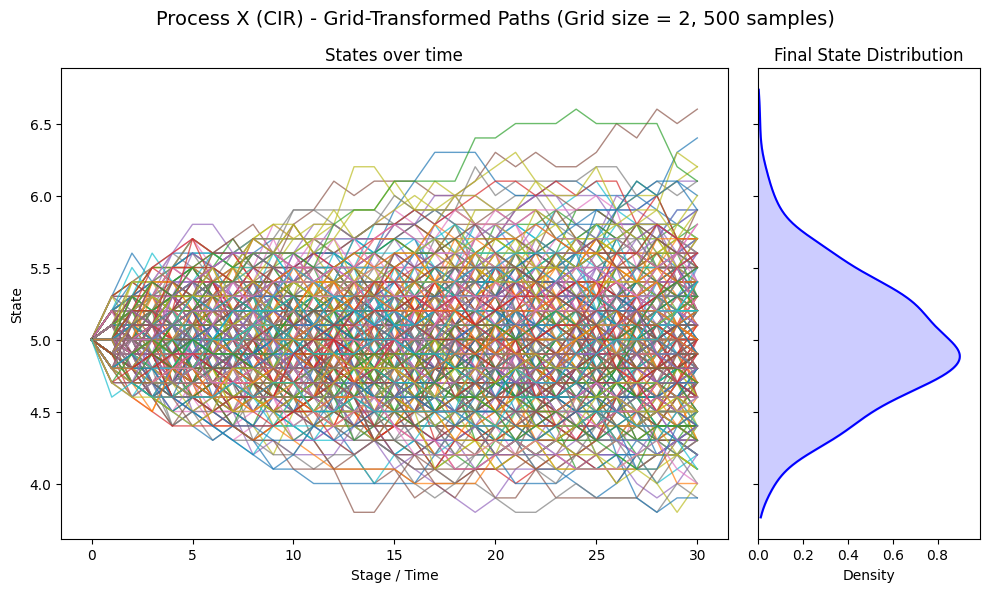

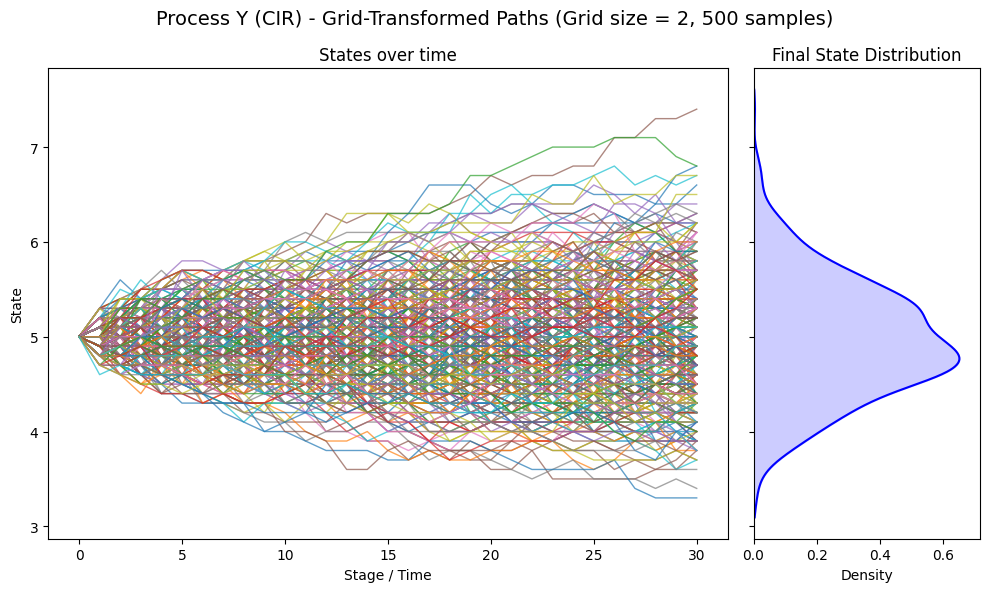

In [4]:
# Simulate CIR processes
X = cir_simulation(n_sample, T, a1, b, sigma, dt, seed)
Y = cir_simulation(n_sample, T, a2, b, sigma, dt, seed)

iid_weights = np.full(n_sample, 1 / n_sample)

# Build and visualize the tree for Process X
root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process X (CIR) - Original Paths (500 samples)",
)

# Build and visualize the tree for Process Y
root = build_tree_from_paths(Y.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process Y (CIR) - Original Paths (500 samples)",
)

# Apply grid quantization for visualization.
fixed_grid_plot = 0.1  # use same grid size for plotting as in the BS notebook

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid_plot, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process X (CIR) - Grid-Transformed Paths (Grid size = 2, 500 samples)",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid_plot, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process Y (CIR) - Grid-Transformed Paths (Grid size = 2, 500 samples)",
)

In [7]:
# -------------------------------
# Experiments: Adapted Wasserstein Squared Distance via Markovian Solver
# -------------------------------

# For experiments we will use a fixed grid for quantization.
fixed_grid = 0.01

# Define sample sizes to test (adjust as needed)
sample_sizes = [30000, 50000, 80000, 120000, 180000, 250000, 500000, 750000, 1000000]
n_runs = 10

results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate a random seed for each run.
        seed = np.random.randint(10000)
        
        # Simulate the CIR processes for the given sample size.
        # Process X uses high mean reversion (a1); Process Y uses low mean reversion (a2).
        X = cir_simulation(n_sample, T, a1, b, sigma, dt, seed)
        Y = cir_simulation(n_sample, T, a2, b, sigma, dt, seed)
        
        # Convert paths to adapted paths using grid quantization.
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping.
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (Markovian).
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.10f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 30000
Run 1: AW_2^2 = 0.5591405108, Time = 30.8279s
Run 2: AW_2^2 = 0.5628597762, Time = 30.6562s
Run 3: AW_2^2 = 0.5648133245, Time = 30.9519s
Run 4: AW_2^2 = 0.5594514159, Time = 31.0280s
Run 5: AW_2^2 = 0.5671288498, Time = 30.6698s
Run 6: AW_2^2 = 0.5654271351, Time = 30.3092s
Run 7: AW_2^2 = 0.5566628753, Time = 30.2533s
Run 8: AW_2^2 = 0.5528335153, Time = 31.0264s
Run 9: AW_2^2 = 0.5624057254, Time = 30.4430s
Run 10: AW_2^2 = 0.5611852617, Time = 30.5515s

Running experiments for sample size: 50000
Run 1: AW_2^2 = 0.5182710318, Time = 35.0796s
Run 2: AW_2^2 = 0.5141173315, Time = 34.7020s
Run 3: AW_2^2 = 0.5197209071, Time = 34.1543s
Run 4: AW_2^2 = 0.5129937522, Time = 34.6339s
Run 5: AW_2^2 = 0.5146323943, Time = 35.6938s
Run 6: AW_2^2 = 0.5182162483, Time = 34.1368s
Run 7: AW_2^2 = 0.5198416509, Time = 33.8839s
Run 8: AW_2^2 = 0.5191938863, Time = 33.5599s
Run 9: AW_2^2 = 0.5196550163, Time = 35.2518s
Run 10: AW_2^2 = 0.5108109608, Time =

In [8]:

aggregated = {}
for n_sample in sorted(results.keys()):
    dists = results[n_sample]["distances"]
    times = results[n_sample]["times"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f}s ± {std_time:.4f}s\n")

samples = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in samples]
std_distances = [aggregated[n]["std_distance"] for n in samples]
mean_times = [aggregated[n]["mean_time"] for n in samples]
std_times = [aggregated[n]["std_time"] for n in samples]

Sample Size: 30000
  Mean AW_2^2: 0.5612 ± 0.0041
  Mean Time: 30.6717s ± 0.2700s

Sample Size: 50000
  Mean AW_2^2: 0.5167 ± 0.0031
  Mean Time: 34.5169s ± 0.6387s

Sample Size: 80000
  Mean AW_2^2: 0.4925 ± 0.0016
  Mean Time: 38.6074s ± 0.5612s

Sample Size: 120000
  Mean AW_2^2: 0.4747 ± 0.0029
  Mean Time: 42.2306s ± 0.7587s

Sample Size: 180000
  Mean AW_2^2: 0.4624 ± 0.0015
  Mean Time: 45.8888s ± 0.3243s

Sample Size: 250000
  Mean AW_2^2: 0.4551 ± 0.0014
  Mean Time: 50.1590s ± 1.2649s

Sample Size: 500000
  Mean AW_2^2: 0.4439 ± 0.0009
  Mean Time: 57.4261s ± 1.2807s

Sample Size: 750000
  Mean AW_2^2: 0.4406 ± 0.0008
  Mean Time: 62.4114s ± 0.7562s

Sample Size: 1000000
  Mean AW_2^2: 0.4383 ± 0.0006
  Mean Time: 63.7719s ± 0.8634s



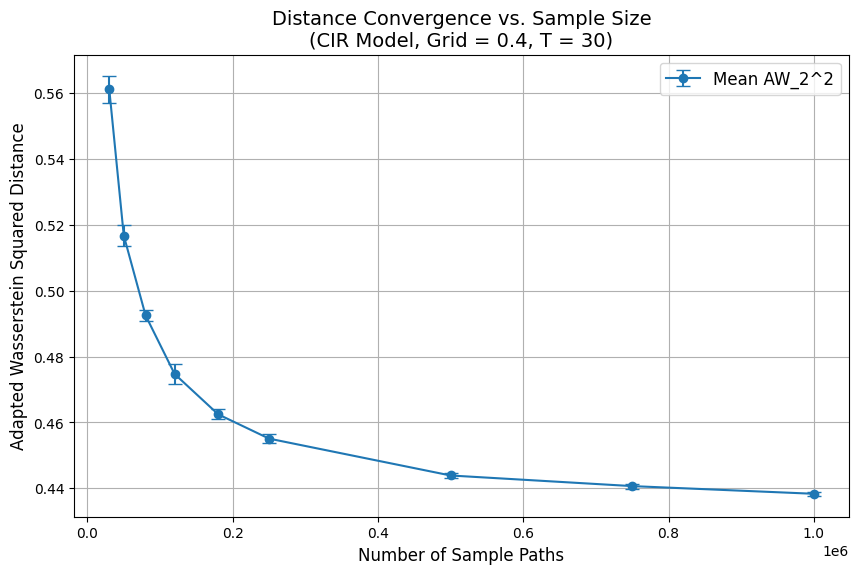

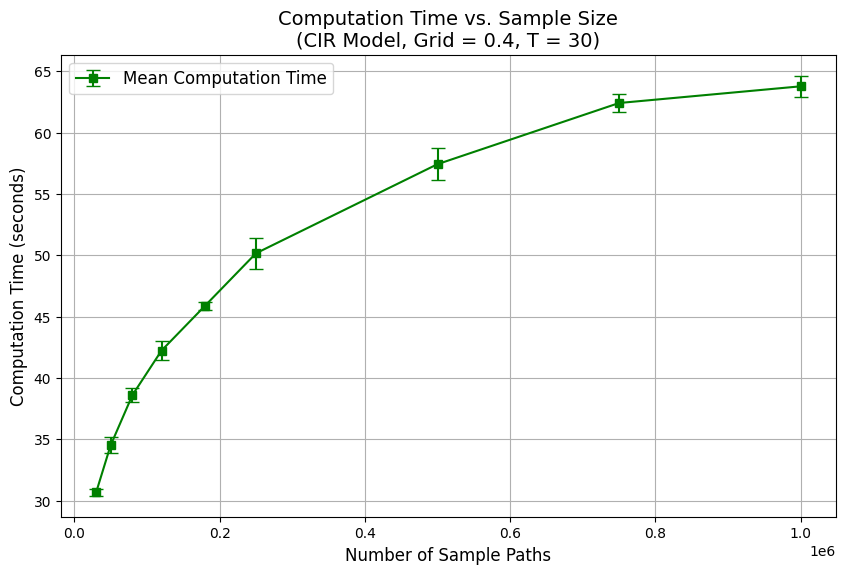

In [9]:
# -------------------------------
# Plotting the Results
# -------------------------------

# Plot 1: Adapted AW_2^2 vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(CIR Model, Grid = 0.01, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(CIR Model, Grid = 0.01, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()